In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d



(150, 500, 3)


(-0.5, 499.5, 149.5, -0.5)

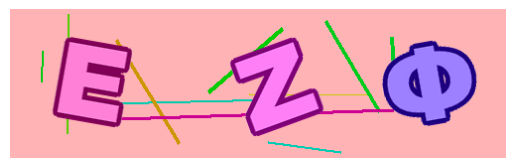

In [2]:
img = cv2.imread('train/43.png')
print(img.shape)
plt.imshow(img)
plt.axis('off')

In [162]:
freq = {}
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if tuple(img[i][j]) in freq:
            freq[tuple(img[i][j])] += 1
        else:
            freq[tuple(img[i][j])] = 1
bg = sorted(freq.items(), key=lambda item: item[1], reverse=True)[0][0]
len(freq)

2283

In [163]:
n = 2
kernel = np.ones((2*n+1,2*n+1),np.uint32)
img = img.astype(int)

img2 = img.copy()
img2[:,:,0] = convolve2d(img[:,:,0], kernel, mode='same', boundary='wrap')
img2[:,:,1] = convolve2d(img[:,:,1], kernel, mode='same', boundary='wrap')
img2[:,:,2] = convolve2d(img[:,:,2], kernel, mode='same', boundary='wrap')

numpix = (2*n+1)**2
img3 = numpix*(img.astype(np.int32))

# if pixel of img3 and img2 are not equal replace that pixel in img with bg
final_img = np.where(img3 != img2, bg, img)

In [164]:

freq = {}
for i in range(final_img.shape[0]):
    for j in range(final_img.shape[1]):
        if tuple(final_img[i][j]) in freq:
            freq[tuple(final_img[i][j])] += 1
        else:
            freq[tuple(final_img[i][j])] = 1
len(freq)

19

In [165]:
sorted(freq.items(), key=lambda item: item[1], reverse=True)

[((255, 179, 181), 69192),
 ((157, 128, 255), 2086),
 ((255, 128, 215), 1865),
 ((255, 128, 246), 1557),
 ((255, 179, 255), 113),
 ((128, 0, 87), 61),
 ((255, 0, 181), 58),
 ((157, 128, 181), 24),
 ((255, 128, 181), 16),
 ((255, 179, 246), 7),
 ((157, 179, 181), 6),
 ((157, 179, 255), 5),
 ((128, 179, 181), 3),
 ((255, 179, 128), 2),
 ((255, 128, 255), 1),
 ((254, 179, 181), 1),
 ((128, 0, 181), 1),
 ((255, 127, 181), 1),
 ((156, 179, 181), 1)]

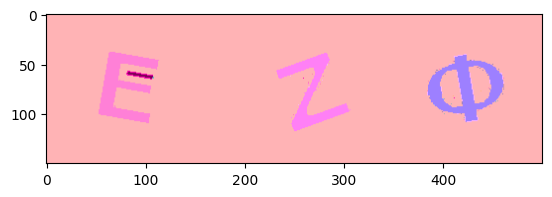

In [166]:
plt.imshow(final_img)

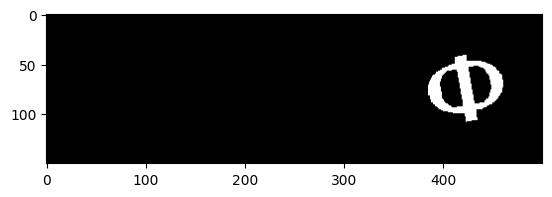

In [170]:
col1 = (157, 128, 255)
image_e = np.zeros(img.shape)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if(tuple(final_img[i,j]) == col1 ):
            image_e[i,j]=1
plt.imshow(image_e)

In [9]:
def remove_lines(img, bg, n=2):
    n = 2
    kernel = np.ones((2*n+1,2*n+1),np.uint32)
    img = img.astype(int)

    img2 = img.copy()
    for i in range(img.shape[2]):
        img2[:,:,i] = convolve2d(img[:,:,i], kernel, mode='same', boundary='wrap')

    numpix = (2*n+1)**2
    img3 = numpix*img

    final_img = np.where(img3 != img2, bg, img)
    return final_img

def get_freq(img):
    freq = {}
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            color = tuple(img[i][j])
            if color in freq:
                freq[color] += 1
            else:
                freq[color] = 1
    return freq

def get_segmented(img, thr=400, th2=3):
    # img: image with lines removed
    freq = get_freq(img)
    freq = {k:v for k,v in freq.items() if v>thr}
    freq = sorted(freq.items(), key=lambda item: item[1], reverse=True)

    col1 = freq[1][0]
    col2 = ()
    col3 = ()
    if len(freq) == 2:
        # all characters are of same colour
        col2 = col1
        col3 = col1
    elif len(freq)==3:
        col2 = freq[2][0]
        col3 = col1
    else:
        col2 = freq[2][0]
        col3 = freq[3][0]

    nrow = img.shape[0]
    ncol = img.shape[1]
    
    hist = [0]*ncol
    for i in range(nrow):
        for j in range(ncol):
            if(tuple(img[i,j]) in [col1, col2, col3] ):
                hist[j] += 1

    imgs = []
    col = 0
    # print(hist)
    for i in range(3):
        start = 0
        stop = 0
        while hist[col]<th2+1:
            col+=1
        start = col
        col+=1
        while hist[col]>=th2 and col<ncol:
            col+=1
        stop = col
        col+=1
        # print(start,stop)
        imgs.append(img[:,start:stop+1,:].astype(np.uint8))

    return imgs
def features(img, th2=3):
    # img: image with lines removed containing only one character
    # returns: 1D array of features
    freq = get_freq(img)
    freq = sorted(freq.items(), key=lambda item: item[1], reverse=True)
    col1 = freq[1][0]
    
    row = 0
    start = 0
    end = 0
    num_nonbg = 0
    while num_nonbg < th2 +1:
        num_nonbg = 0
        for i in range(img.shape[1]):
            if(tuple(img[row,i]) == col1):
                num_nonbg+=1
        row+=1
    start = row-1
    
    row = img.shape[0]-1
    num_nonbg = 0
    while num_nonbg < th2 +1:
        num_nonbg = 0
        for i in range(img.shape[1]):
            if(tuple(img[row,i]) == col1):
                num_nonbg+=1
        row-=1
    end = row+1
    
    img = img[start:end+1,:,:]
    binimg = np.zeros(img.shape, dtype = np.uint8) 
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if(tuple(img[i,j]) == col1):
                binimg[i,j] = 255

    return binimg

In [10]:
def preprocess(img, kernel_size = 2, freq_threshold = 400, pixel_threshold = 3):
    '''
    ARGUMENTS:
    img: input image.
    kernel size: for convolution used for erosion.
    freq_threshold: to ignore colors of frequency less than this.
    pixel_therhold: ignore cols that contains less non-bg pixels than this.

    # RETURNS:
    imgs: a list of 3 images each containing a single character
    '''

    freq_org = get_freq(img)
    bg_color = max(zip(freq_org.values(), freq_org.keys()))[1]
    
    lines_removed = remove_lines(img, bg_color, kernel_size)

    return get_segmented(lines_removed, freq_threshold, pixel_threshold)

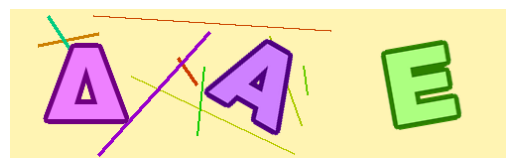

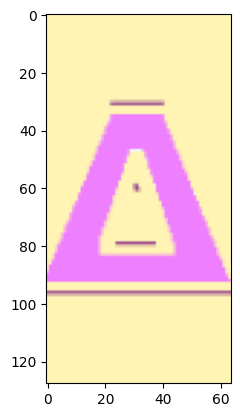

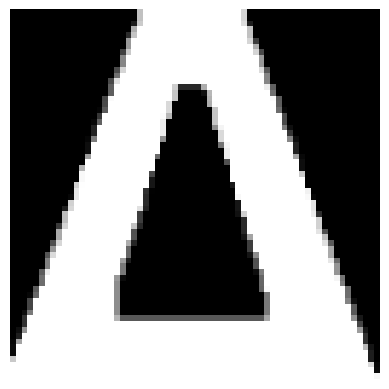

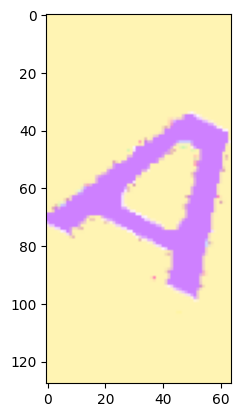

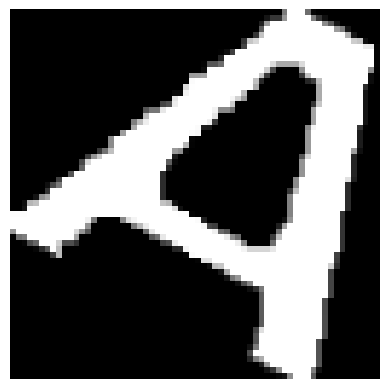

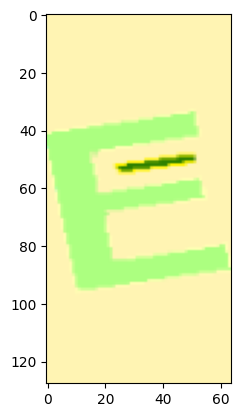

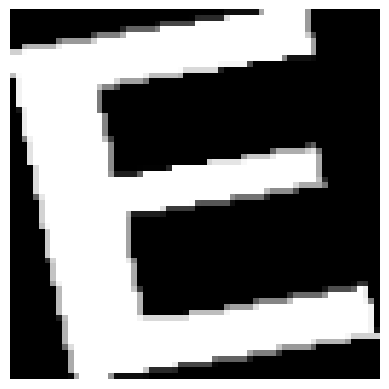

In [13]:
img = cv2.imread('train/1.png')

plt.imshow(img)
plt.axis('off')
plt.show()

imgs = preprocess(img)
for chars in imgs:
    plt.imshow(cv2.resize(chars, (64,128)))
    plt.show()
    plt.imshow(cv2.resize(features(chars), (64,64)), cmap='gray')
    plt.axis('off')
    plt.show()

In [290]:
import os
path = 'train'
img_paths = os.listdir(path)
labels = open('labels.txt').read().split('\n')
reference_size = (64,128)
n_train = 1900
k=0
for imgpath in img_paths[:n_train]:
    num = int(imgpath.split('.')[0])
    imgpath = os.path.join(path, imgpath)
    img = cv2.imread(imgpath)
    imgs = preprocess(img)
    for i in range(len(imgs)):
        label = labels[num].split(',')[i]
        direc = os.path.join('prc_train', label)
        if not os.path.isdir(direc):
            os.mkdir(direc)
        finalimg = cv2.resize(imgs[i], reference_size)
        imgname = os.path.join(direc, str(k*3+i)+'.png')
        cv2.imwrite(imgname, finalimg)
    k+=1
        
for imgpath in img_paths[n_train:]:
    final_path =os.path.join('test', imgpath)
    imgpath = os.path.join(path, imgpath)
    img = cv2.imread(imgpath)
    cv2.imwrite(final_path,img)

